In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import h5py
import scipy.interpolate
from matplotlib.pyplot import figure
import glob
import imageio.v3 as iio


from asispectralinversion.inversion import *
from asispectralinversion.preprocessing import *
from asispectralinversion.pullfiles import *

#from asi_inv import *
from apexpy import Apex

# Copies an HDF5 structure to a python dict recursively
def copy_h5(vtest):
    # Initialize dict to output
    dicttest = {}
    # List of keys in dataset
    keyslist = list(vtest.keys())
    # Iterate through keys
    for key in keyslist:
        # vtest[key] is an array
        if type(vtest[key]) == h5py._hl.dataset.Dataset:
            # vtest[key] is a 0d or 1d array
            if vtest[key].shape[1] == 1:
                # vtest[key] is a 0d array
                if vtest[key].shape[0] == 1:
                    # extract the float value of vtest[key]
                    dicttest[key] = vtest[key][0][0]
                # vtest[key] is a 1d array
                else:
                    # extract the numpy array
                    dicttest[key] = np.asarray(vtest[key]).flatten()
            # vtest[key] is a 2 or more dimensional array
            else:
                # extract the numpy array
                dicttest[key] = np.asarray(vtest[key])
        # vtest[key] is another hdf5 structure
        else:
            # Recursively apply copy_h5 to the sub-structure
            dicttest[key] = copy_h5(vtest[key])
    return dicttest

/home/alexander/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# THINGS TO ADD:

## - Add second order inversion

# Choose a date

In [2]:
# Right now we have March 14 and 19 for examples
date = '20230314'
#date = '20230319'
dtdate = datetime.date(int(date[:4]),int(date[4:6]),int(date[6:]))

## Other parameters

In [3]:
maglatsite = 65.8
# Gaussian blur width in degrees maglon
blur_deg_EW = 0.4
# Gaussian blur width in degrees maglat (should be smaller!)
blur_deg_NS = 0.04

# n_shifts, integer determining shift-invariance of wavelets (higher is better, but slower and has diminishing returns)
n_shifts = 30


# Do we use dark patches in the sky to set background brightness, or just use the corners?
background_method = 'patches'
#background_method = 'corners'

## Let's start with a quick self-test: after reading in our inversion tables, we sample RGB brightnesses and see how well we can invert back to what we started with

In [4]:
folder = 'test_data_'+date+'/'

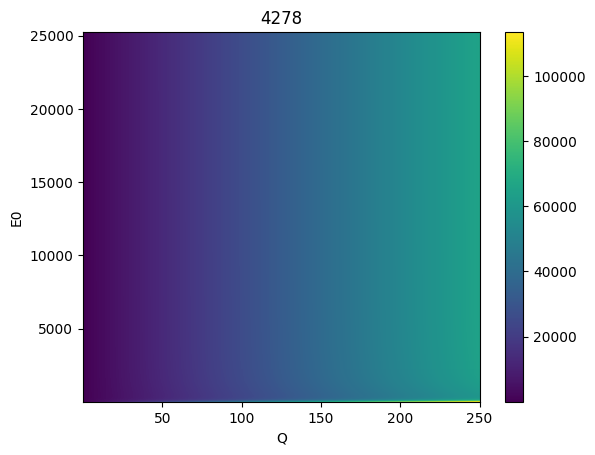

In [5]:
v = load_lookup_tables_directory(folder,maglatsite,plot=True)

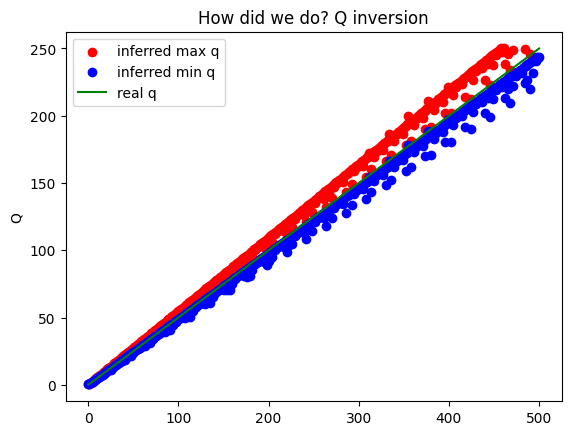

In [6]:
# A bunch of E0s to sample
trueE0vec = np.amax(v['E0vec'])*0.95*(np.sin(v['Qvec']/0.5))**2 + 150
# The closest indices for each E0
trueE0indvec = np.asarray([np.argmin(np.abs(v['E0vec']-trueE0vec[i])) for i in range(len(trueE0vec))])
# We use every q index
qindvec = np.arange(len(v['Qvec']))

# Every Q value
Qvectest = v['Qvec'][qindvec]
# The nearest "snapped" E0 values to the ones we chose
E0vectest = v['E0vec'][trueE0indvec]
e0order = np.argsort(E0vectest)

################ PLOTTING ################
plt.pcolormesh(v['Qvec'],v['E0vec'],np.log(v['redmat']/v['greenmat']))
#plt.scatter(v['Qvec'],trueE0vec,color='pink')
plt.scatter(Qvectest,E0vectest,color='red')
plt.xlabel('Q')
plt.ylabel('E0')
plt.title('sampling the whole space!')
plt.show()
################          ################
# Pulling out RGB values
greentrace = np.asarray([v['greenmat'][trueE0indvec[i],qindvec[i]] for i in range(len(qindvec))])
redtrace = np.asarray([v['redmat'][trueE0indvec[i],qindvec[i]] for i in range(len(qindvec))])
bluetrace = np.asarray([v['bluemat'][trueE0indvec[i],qindvec[i]] for i in range(len(qindvec))])

# Removing airglow
greentrace -= v['greenbright_airglow'][0][0]
redtrace -= v['redbright_airglow'][0][0]
bluetrace -= v['bluebright_airglow'][0][0]


logredtrace = np.log(redtrace)
logratiotrace = np.log(redtrace/greentrace)

################ PLOTTING ################
# plt.scatter(trueE0vec[np.argsort(trueE0vec)],bluetrace[np.argsort(trueE0vec)],color='blue',s=5)
# #plt.scatter(trueE0vec[np.argsort(trueE0vec)][np.where(bluetrace[np.argsort(trueE0vec)]>maxbluebright)],bluetrace[np.argsort(trueE0vec)][np.where(bluetrace[np.argsort(trueE0vec)]>maxbluebright)],color='red',s=5)

# plt.title('Red points have too high of a blue brightness')
# plt.xlabel('E0')
# plt.ylabel('Blue Brightness')
# plt.show()
################          ################
# Inferring Q
#qoutvec,maxqvec,minqvec =  q_interp(v['bluemat'],v['Qvec'],v['E0vec'],bluetrace,minE0ind=59,maxbluebright='auto',interp='linear',plot=False)
qoutvec,e0outvec,minqvec,maxqvec,mine0vec,maxe0vec = calculate_E0_Q_v2(redtrace,greentrace,bluetrace,v,minE0=150,generous=True,plot=False)


################ PLOTTING ################
# How did we do?
plt.scatter(np.arange(len(qoutvec)),maxqvec,color='red',label='inferred max q')
plt.scatter(np.arange(len(qoutvec)),minqvec,color='blue',label='inferred min q')
plt.plot(np.arange(len(qoutvec)),Qvectest,color='green',label='real q')
plt.title('How did we do? Q inversion')
plt.legend()
plt.ylabel('Q')
plt.show()

plt.title('How did we do? Q inversion')
plt.scatter(np.arange(len(qoutvec)),Qvectest,color='green',label='real q')
plt.scatter(np.arange(len(qoutvec)),qoutvec,color='purple',label='best guess',s=5)
plt.scatter(np.arange(len(qoutvec))[np.where(np.isnan(maxqvec+minqvec))],qoutvec[np.where(np.isnan(maxqvec+minqvec))],color='red',label='no valid bounds',s=5)

plt.legend()
plt.ylabel('Q')
plt.show()
################          ################

# Inferring E0
#e0outvec = e0_interp_general(v['redmat']/v['greenmat'],v['Qvec'],v['E0vec'],(redtrace/greentrace),qoutvec)
#e0ext1,e0ext2 = e0_interp_general(v['redmat']/v['greenmat'],v['Qvec'],v['E0vec'],(redtrace/greentrace),maxqvec),e0_interp_general(v['redmat']/v['greenmat'],v['Qvec'],v['E0vec'],(redtrace/greentrace),minqvec)

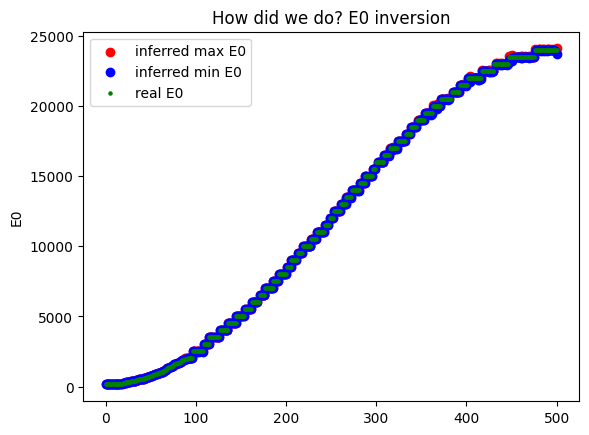

Text(0, 0.5, 'E0')

In [7]:
plt.scatter(np.arange(len(qoutvec)),maxe0vec[e0order],color='red',label='inferred max E0')
plt.scatter(np.arange(len(qoutvec)),mine0vec[e0order],color='blue',label='inferred min E0')
plt.scatter(np.arange(len(qoutvec)),E0vectest[e0order],color='green',s=5,label='real E0')
plt.legend()
plt.ylabel('E0')
plt.title('How did we do? E0 inversion')
plt.show()

plt.scatter(np.arange(len(qoutvec)),E0vectest[e0order],color='green',label='real E0',s=100)
plt.scatter(np.arange(len(qoutvec)),e0outvec[e0order],color='purple',s=20,label='best guess')
plt.title('How did we do? E0 inversion')
plt.legend()
plt.ylabel('E0')

In [8]:
print('median absolute Q % error')
medqerror = np.median((100*np.abs((qoutvec-Qvectest))/Qvectest)[np.where(~np.isnan(np.abs((qoutvec-Qvectest))/Qvectest))])
print(str(np.round(medqerror,3))+'%')

print('median absolute E0 % error')
mede0error = np.median((100*np.abs((e0outvec-E0vectest))/E0vectest)[np.where(~np.isnan(np.abs((e0outvec-E0vectest))/E0vectest))])
print(str(np.round(mede0error,3))+'%')

median absolute Q % error
0.061%
median absolute E0 % error
0.001%


# Now let's try inverting real imagery data

## Let's try pulling directly from the OPTICS site using the download_imagery script
Note that this has only been tested on linux...
If this doesn't work, uncomment the block that reads in .mat files

In [9]:
# For 0314, the Swarm crossing of the arc happens at roughly 6:48 - 6:50 UT.
# Change this manually as needed

# Download all DASC imagery between these times to a local directory:
download_imagery(date,'064800','065000')

In [10]:
# Change this manually as needed, it is set up for 0314

# Read in red images
redim0 = iio.imread(date+'/PKR_20230314_064904_0630.png')
redim1 = iio.imread(date+'/PKR_20230314_064912_0630.png')
redim2 = iio.imread(date+'/PKR_20230314_064920_0630.png')

# Read in green images
greenim0 = iio.imread(date+'/PKR_20230314_064902_0558.png')
greenim1 = iio.imread(date+'/PKR_20230314_064910_0558.png')
greenim2 = iio.imread(date+'/PKR_20230314_064918_0558.png')

# Read in blue images
blueim0 = iio.imread(date+'/PKR_20230314_064859_0428.png')
blueim1 = iio.imread(date+'/PKR_20230314_064907_0428.png')
blueim2 = iio.imread(date+'/PKR_20230314_064915_0428.png')

# Co-add the images
redimcoadd = (redim0+redim1+redim2)/3
greenimcoadd = (greenim0+greenim1+greenim2)/3
blueimcoadd = (blueim0+blueim1+blueim2)/3

/home/alexander/.local/lib/python3.10/site-packages/imageio/plugins/pillow.py:320: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


## Uncomment the following block if you don't want to download the imagery, or if it doesn't work

In [11]:
# redims = copy_h5(h5py.File(folder+'reddata.mat'))
# greenims = copy_h5(h5py.File(folder+'greendata.mat'))
# blueims = copy_h5(h5py.File(folder+'bluedata.mat'))

# greenimcoadd = (greenims['frame1']+greenims['frame2']+greenims['frame3'])/3
# blueimcoadd = (blueims['frame1']+blueims['frame2']+blueims['frame3'])/3
# redimcoadd = (redims['frame1']+redims['frame2']+redims['frame3'])/3

Note that there are separate copies of identical skymaps in each folder.

We anticipate eventually using different skymaps, so this was done to start the bookkeeping for that process

In [12]:
# Read in the skymap and extract the values for each color

vskymap = copy_h5(h5py.File(folder+'skymap.mat')['magnetic_footpointing'])
skymapred = [vskymap['180km']['lat'],vskymap['180km']['lon']]
skymapgreen = [vskymap['110km']['lat'],vskymap['110km']['lon']]
skymapblue = [vskymap['107km']['lat'],vskymap['107km']['lon']]

In [13]:
# plt.imshow(redims['frame2'])
# plt.title('red imagery')
# plt.show()
# plt.imshow(greenims['frame2'])
# plt.title('green imagery')
# plt.show()
# plt.imshow(blueims['frame2'])
# plt.title('blue imagery')
# plt.show()

## We start by stacking the 3 frames for each color to suppress noise slightly

In [14]:
# # Or we only stack blue...

# greenimcoadd = greenims['frame2']
# blueimcoadd = (blueims['frame1']+blueims['frame2']+blueims['frame3'])/3
# redimcoadd = redims['frame2']

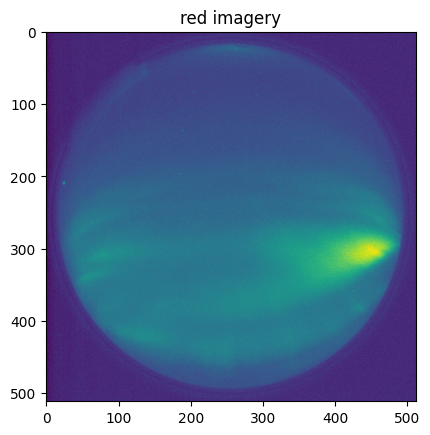

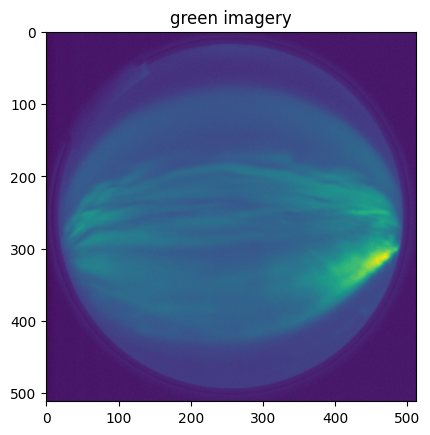

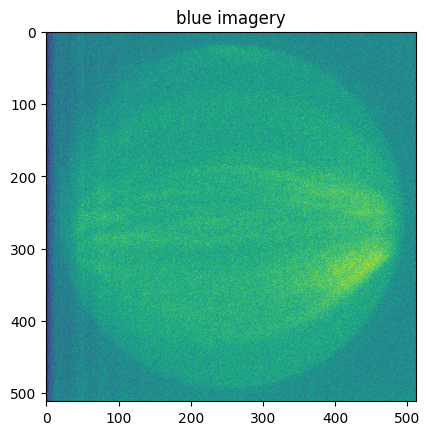

In [15]:
plt.imshow(redimcoadd)
plt.title('red imagery')
plt.show()
plt.imshow(greenimcoadd)
plt.title('green imagery')
plt.show()
plt.imshow(blueimcoadd)
plt.title('blue imagery')
plt.show()

## The blue imagery has significant artifacts, so let's try a dark frame subtraction!

In [16]:
blueimcoaddold = np.copy(blueimcoadd)
darkframe = iio.imread('biasframes/blue_bias_processed.png').astype('float')/10
darkframe -= np.mean(darkframe)

In [17]:
rawdarkframe = iio.imread('biasframes/blue_bias_raw.png').astype('float')/10
rawdarkframe -= np.mean(rawdarkframe)

In [18]:
plt.imshow(darkframe,vmin=-10,vmax=10,cmap='seismic')
plt.colorbar()
plt.show()
plt.imshow(rawdarkframe,vmin=-10,vmax=10,cmap='seismic')
plt.colorbar()
plt.show()
plt.imshow(rawdarkframe-darkframe,vmin=-10,vmax=10,cmap='seismic')
plt.colorbar()

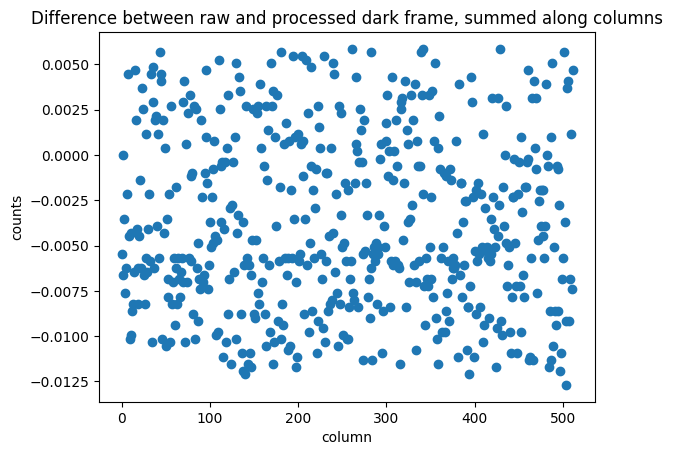

Text(0.5, 0, 'column')

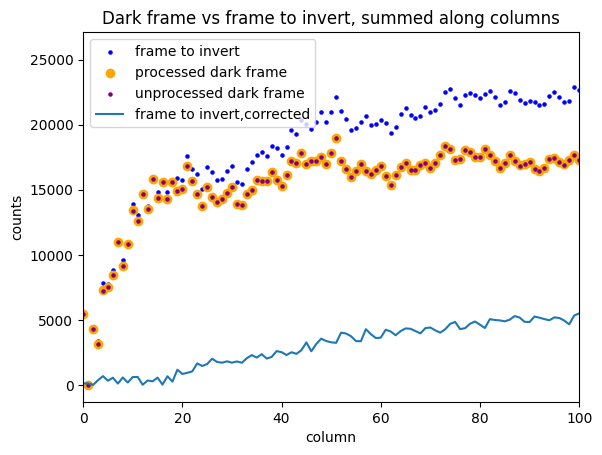

In [19]:
plt.scatter(np.linspace(0,511,512),((np.sum(rawdarkframe,axis=0)-np.amin(np.sum(rawdarkframe,axis=0)))-((np.sum(darkframe,axis=0)-np.amin(np.sum(darkframe,axis=0)))))/512,label='processed dark frame')
plt.title('Difference between raw and processed dark frame, summed along columns')
plt.ylabel('counts')
plt.xlabel('column')
plt.show()
plt.title('Dark frame vs frame to invert, summed along columns')
plt.scatter(np.linspace(0,511,512),np.sum(blueimcoaddold,axis=0)-np.amin(np.sum(blueimcoaddold,axis=0)),s=5,color='blue',label='frame to invert')
plt.scatter(np.linspace(0,511,512),(np.sum(darkframe,axis=0)-np.amin(np.sum(darkframe,axis=0))),color='orange',label='processed dark frame')
plt.scatter(np.linspace(0,511,512),(np.sum(rawdarkframe,axis=0)-np.amin(np.sum(rawdarkframe,axis=0))),s=5,color='purple',label='unprocessed dark frame')
plt.plot(np.linspace(0,511,512),np.sum(blueimcoaddold-darkframe,axis=0)-np.amin(np.sum(blueimcoaddold-darkframe,axis=0)),label='frame to invert,corrected')

plt.legend()
plt.xlim(0,100)
plt.ylabel('counts')
plt.xlabel('column')


In [20]:
blueimcoadd = blueimcoaddold-darkframe

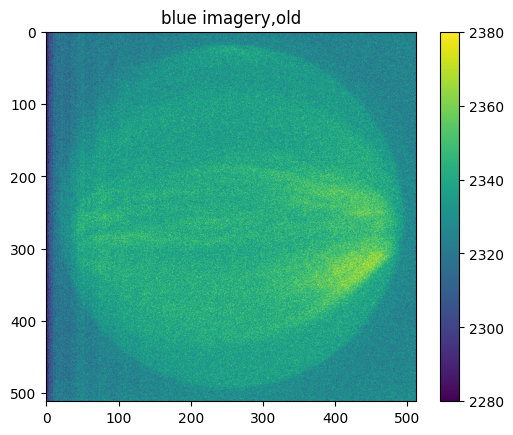

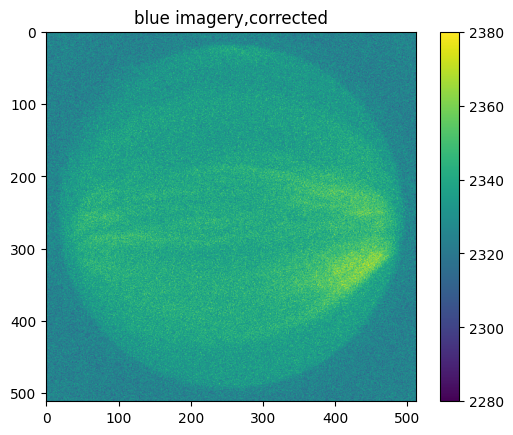

In [21]:
plt.imshow(blueimcoaddold,vmin=2280,vmax=2380)
plt.title('blue imagery,old')
plt.colorbar()
plt.show()
plt.imshow(blueimcoadd,vmin=2280,vmax=2380)
plt.title('blue imagery,corrected')
plt.colorbar()
plt.show()
# plt.imshow(blueimcoaddold-rawdarkframe,vmin=2280,vmax=2380)
# plt.title('blue imagery,corrected alternate')
# plt.colorbar()
# plt.show()

## We initialize Apex - we are going to remap these 3 images onto the same new grid

In [22]:
A = Apex(date=dtdate)
bmla, bmlo = A.convert(skymapblue[0].reshape(-1), np.mod(skymapblue[1].reshape(-1),360), 'geo', 'apex', height=110)

minmlat = np.amin(bmla[np.where(~np.isnan(bmla))])
maxmlat = np.amax(bmla[np.where(~np.isnan(bmla))])

minmlon = np.amin(bmlo[np.where(~np.isnan(bmlo))])
maxmlon = np.amax(bmlo[np.where(~np.isnan(bmlo))])

# rmla, rmlo = A.convert(skymapred[0].reshape(-1), np.mod(skymapred[1].reshape(-1),360), 'geo', 'apex', height=110)

# minmlat = np.amin(rmla[np.where(~np.isnan(rmla))])
# maxmlat = np.amax(rmla[np.where(~np.isnan(rmla))])

# minmlon = np.amin(rmlo[np.where(~np.isnan(rmlo))])
# maxmlon = np.amax(rmlo[np.where(~np.isnan(rmlo))])


interplonvec = np.linspace(minmlon,maxmlon,1026)
interplatvec = np.linspace(minmlat,maxmlat,1024)

/home/alexander/.local/lib/python3.10/site-packages/apexpy/apex.py:552: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  alat, alon = self._geo2apex(glat, glon, height)
/home/alexander/.local/lib/python3.10/site-packages/apexpy/apex.py:555: UserWarning: Apex latitude set to NaN where undefined (apex height may be < reference height)
  warnings.warn(''.join(['Apex latitude set to NaN where undefined ',


## We remap the images onto our new grid, while also denoising and estimating background brightness and initial noise level

### In this example, we use a Bayesian wavelet based denoising algorithm to blur the image as little as possible
nshifts is a parameter controlling the shift-invariance of the wavelets, and should probably be set between 5 and 70, or so... 
Here we set nshifts=30 to speed up computation, but its default value is 50 (I probably set it higher than necessary)

/home/alexander/asispectralinversion/src/asispectralinversion/preprocessing.py:80: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(lon,lat,im)


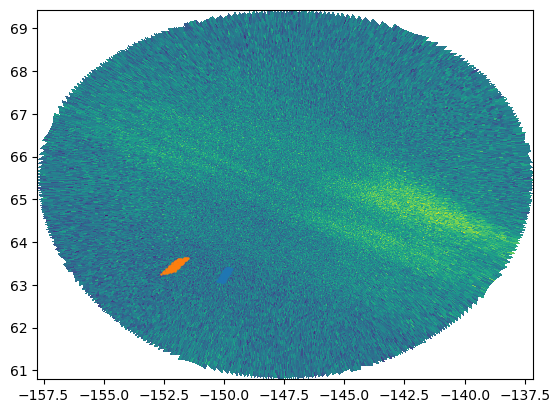

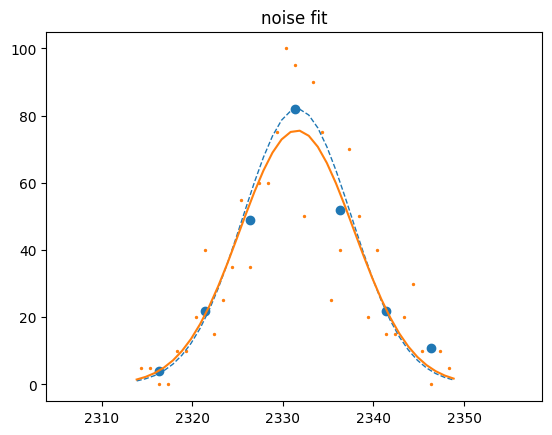

/home/alexander/asispectralinversion/src/asispectralinversion/preprocessing.py:170: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(lon,lat,im,vmin=cent-4*sig,vmax=cent+4*sig,cmap='seismic')


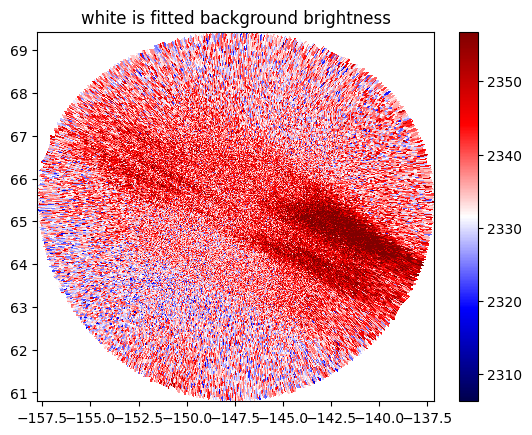

/home/alexander/.local/lib/python3.10/site-packages/skimage/_shared/utils.py:316: UserWarning: The optional dask dependency is not installed. The number of workers is set to 1. To silence this warning, install dask or explicitly set `num_workers=1` when calling the `cycle_spin` function
  return func(*args, **kwargs)
/home/alexander/asispectralinversion/src/asispectralinversion/preprocessing.py:379: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(lon,lat,im,vmin=np.amin(regimblur[np.where(~np.isnan(regimblur))]),vmax=np.amax(regimblur[np.where(~np.isnan(regimblur))]))


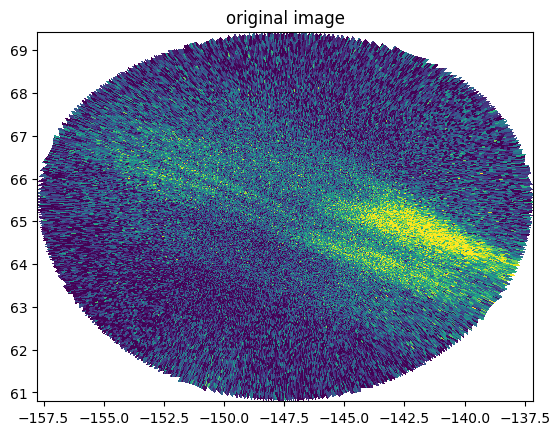

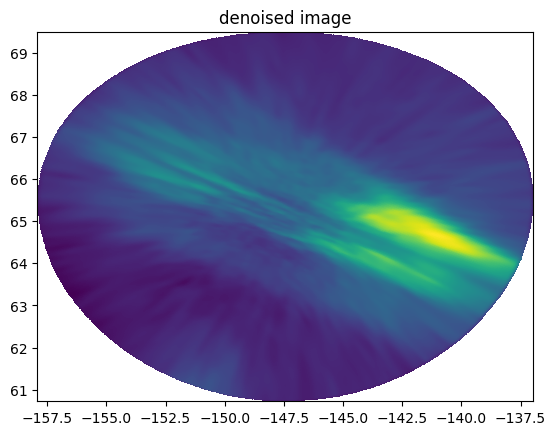

In [23]:
blueimdenoisewavelet,blueimreg,lon110,lat110,maglon,maglat,bluebgbright,bluesig = wavelet_denoise_resample(blueimcoadd,dtdate,skymapblue[1],skymapblue[0],interplonvec,interplatvec,110,nshifts=n_shifts,background_method=background_method,plot=True)

## Try again with gaussian blurring - note that there is intentionally significantly more blurring in the E-W than N-S direction

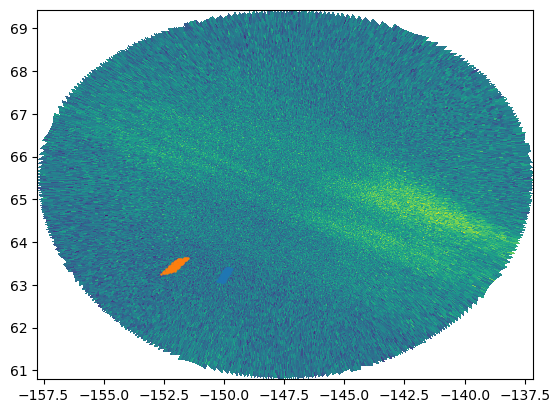

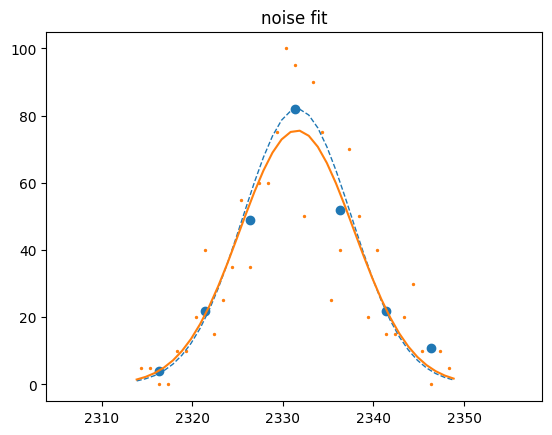

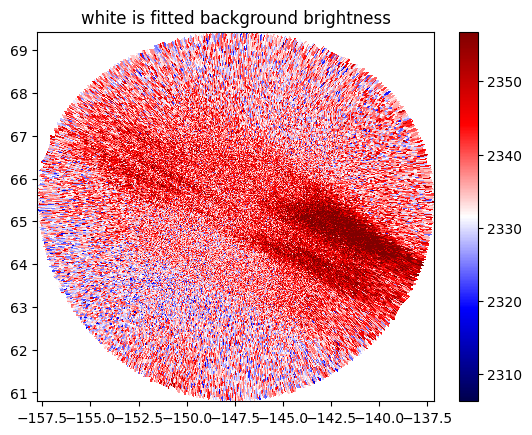

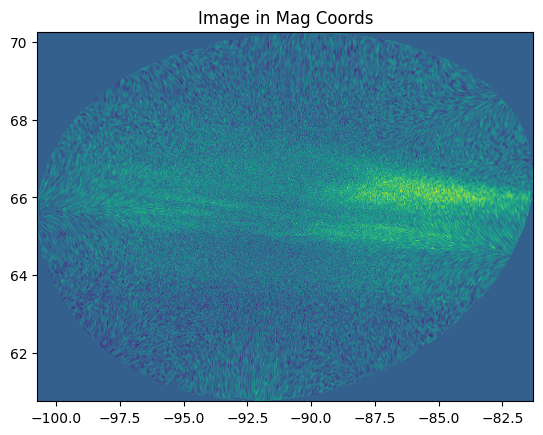

/home/alexander/asispectralinversion/src/asispectralinversion/preprocessing.py:300: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(lon,lat,im,vmin=np.amin(regimblur[np.where(~np.isnan(regimblur))]),vmax=np.amax(regimblur[np.where(~np.isnan(regimblur))]))


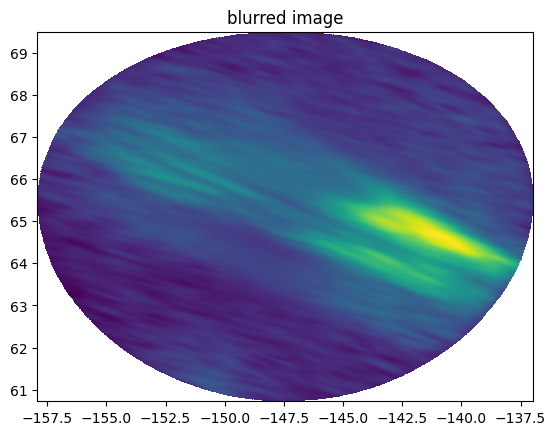

In [24]:
blueimdenoisegauss,_,_,_,_,_,_,_ = gaussian_denoise_resample(blueimcoadd,dtdate,skymapblue[1],skymapblue[0],interplonvec,interplatvec,110,blur_deg_EW,NS_deg=blur_deg_NS,plot=True)

## Let's compare the residual from denoising to a simulated noise field from our background fitting

In [25]:
noise = np.copy(skymapblue[0]).reshape(-1)
noiseadd = (np.random.randn(len(noise[np.where(~np.isnan(noise))]))*bluesig)
noise[np.where(~np.isnan(noise))] = noiseadd
noise = noise.reshape(skymapblue[0].shape)

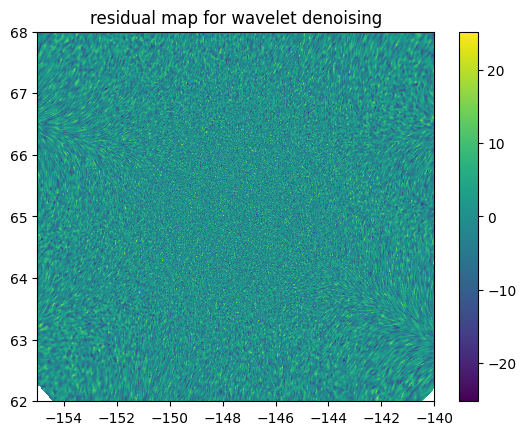

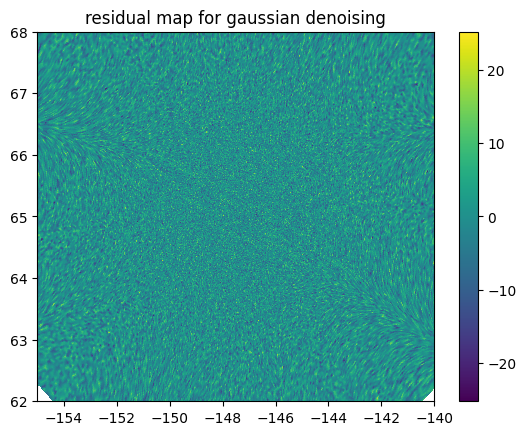

/tmp/ipykernel_20057/3062563493.py:14: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(skymapgreen[1],skymapgreen[0],noise,vmin=-4*bluesig,vmax=4*bluesig)
/tmp/ipykernel_20057/3062563493.py:17: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


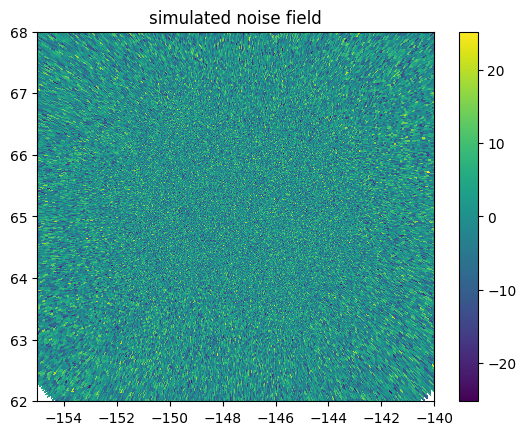

In [26]:
plt.pcolormesh(lon110,lat110,blueimreg-blueimdenoisewavelet,vmin=-4*bluesig,vmax=4*bluesig)
plt.title('residual map for wavelet denoising')
plt.xlim(-155,-140)
plt.ylim(62,68)
plt.colorbar()
plt.show()
plt.pcolormesh(lon110,lat110,blueimreg-blueimdenoisegauss,vmin=-4*bluesig,vmax=4*bluesig)
plt.title('residual map for gaussian denoising')
plt.xlim(-155,-140)
plt.ylim(62,68)
plt.colorbar()
plt.show()
plt.title('simulated noise field')
plt.pcolor(skymapgreen[1],skymapgreen[0],noise,vmin=-4*bluesig,vmax=4*bluesig)
plt.xlim(-155,-140)
plt.ylim(62,68)
plt.colorbar()


## We use wavelet denoising on the red and green channels, or uncomment the gaussian denoising instead

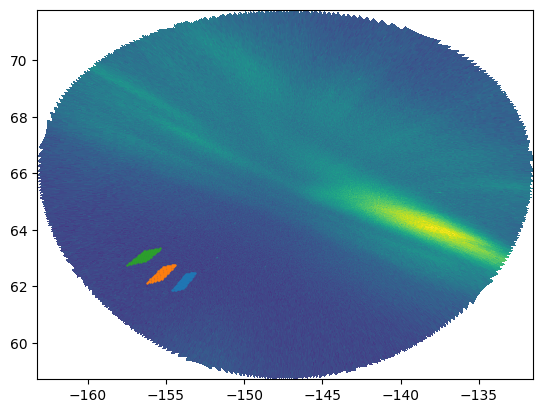

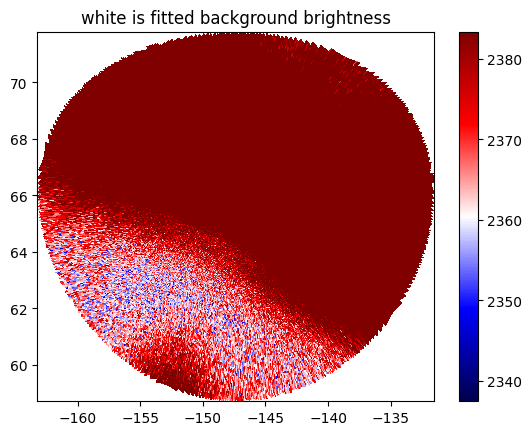

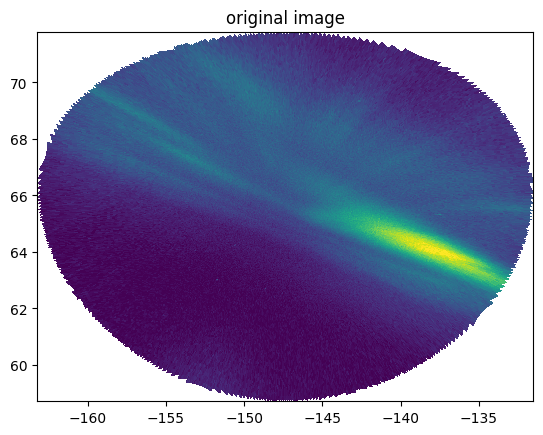

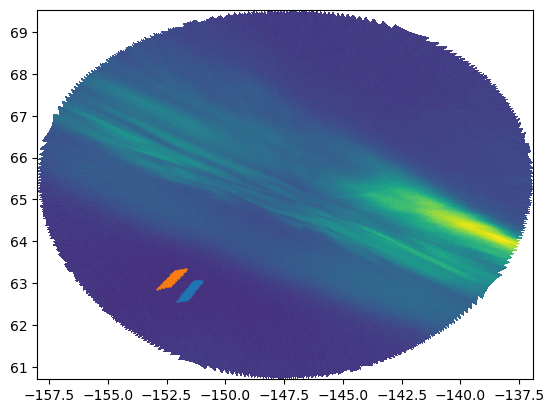

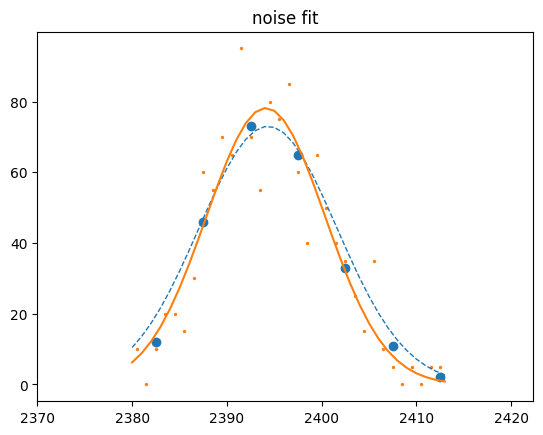

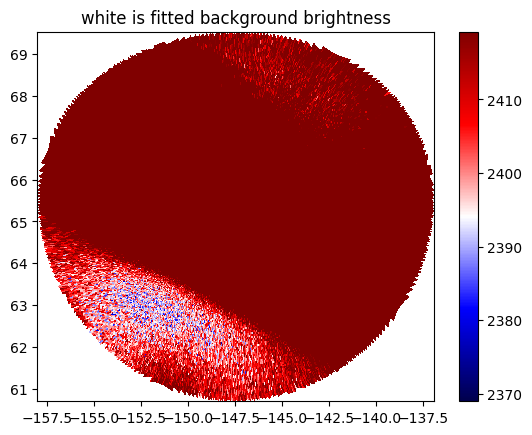

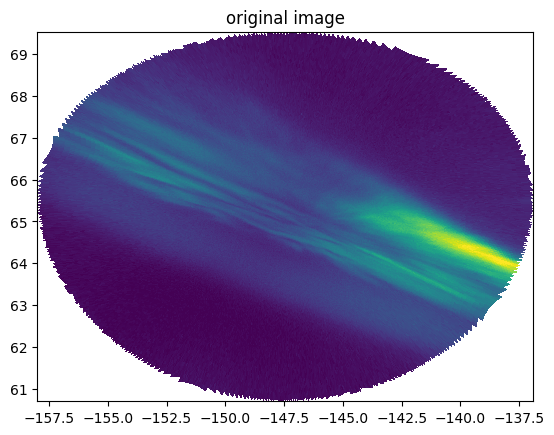

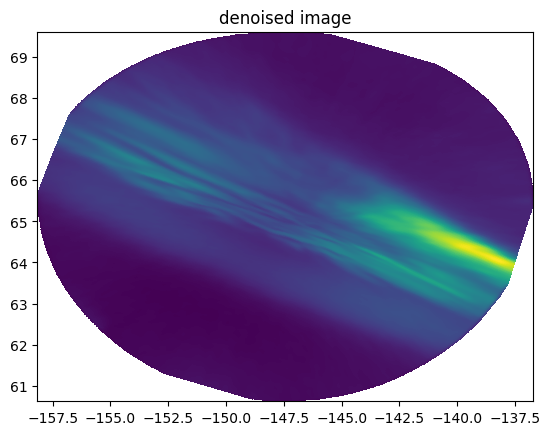

In [27]:
redimdenoise,redimreg,_,_,_,_,redbgbright,redsig = wavelet_denoise_resample(redimcoadd,dtdate,skymapred[1],skymapred[0],interplonvec,interplatvec,110,nshifts=n_shifts,background_method=background_method,plot=True)
greenimdenoise,greenimreg,_,_,_,_,greenbgbright,greensig = wavelet_denoise_resample(greenimcoadd,dtdate,skymapgreen[1],skymapgreen[0],interplonvec,interplatvec,110,nshifts=n_shifts,background_method=background_method,plot=True)
blueimdenoise = np.copy(blueimdenoisewavelet)
# redimdenoise,redimreg,_,_,_,_,redbgbright,redsig = gaussian_denoise_resample(redimcoadd,dtdate,skymapred[1],skymapred[0],interplonvec,interplatvec,110,blur_deg_EW,NS_deg=blur_deg_NS,plot=True)
# greenimdenoise,greenimreg,_,_,_,_,greenbgbright,greensig = gaussian_denoise_resample(greenimcoadd,dtdate,skymapgreen[1],skymapgreen[0],interplonvec,interplatvec,110,blur_deg_EW,NS_deg=blur_deg_NS,plot=True)
# blueimdenoise = np.copy(blueimdenoisegauss)

Text(0.5, 1.0, 'mapped image, original, magnetic coords')

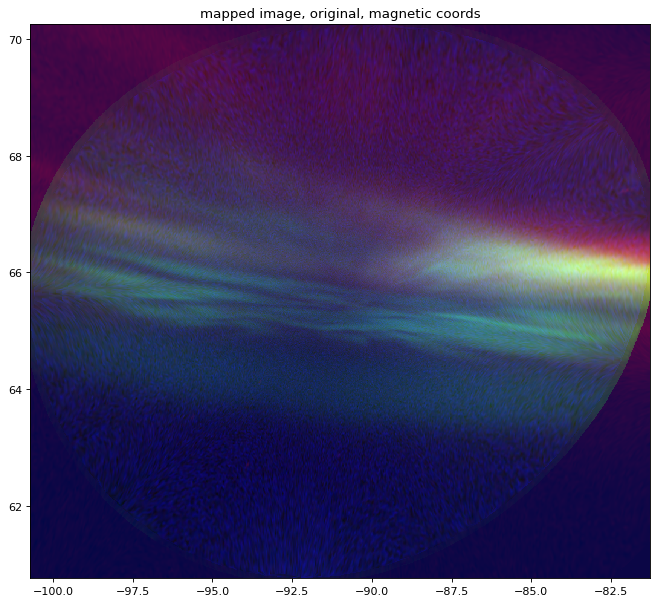

In [28]:
# This is just a visualization tool - we tried to strike a balance between brightening the dim colors and allowing them to overwhelm the image

ngreen = (1/np.std(greenimreg[np.where(~np.isnan(greenimreg))]))**(6.5/8)
nred = (1/np.std(redimreg[np.where(~np.isnan(redimreg))]))**(6.5/8)
nblue = (1/np.std(blueimreg[np.where(~np.isnan(blueimreg))]))**(6.5/8)

greenframe = np.copy(greenimreg)
greenframe[np.where(np.isnan(greenframe))] = greenbgbright

blueframe = np.copy(blueimreg)
blueframe[np.where(np.isnan(blueframe))] = bluebgbright

redframe = np.copy(redimreg)
redframe[np.where(np.isnan(redframe))] = redbgbright


greenmin = np.amin(greenframe)
bluemin = np.amin(blueframe)
redmin = np.amin(redframe)

# ngreen=100/np.median(greenframe-greenmin)
# nred = 100/np.median(redframe-redmin)
# nblue=100/np.median(blueframe-bluemin)


#colormat = np.asarray([3*(redframe-redmin),(greenframe-greenmin),10*(blueframe-bluemin)]).astype(float)
colormat = np.asarray([nred*(redframe-redmin),ngreen*(greenframe-greenmin),nblue*(blueframe-bluemin)]).astype(float)

maxbright = np.amax(colormat)

colormat /= maxbright

fig = figure(figsize=(10, 9), dpi=80)
fig.canvas.header_visible = False
mesh = plt.pcolormesh(maglon.T,maglat.T,greenframe.T,facecolors=colormat.T.reshape(-1,3))
mesh.set_array(None)
plt.title('mapped image, original, magnetic coords')

Text(0.5, 1.0, 'mapped image, denoised, magnetic coords')

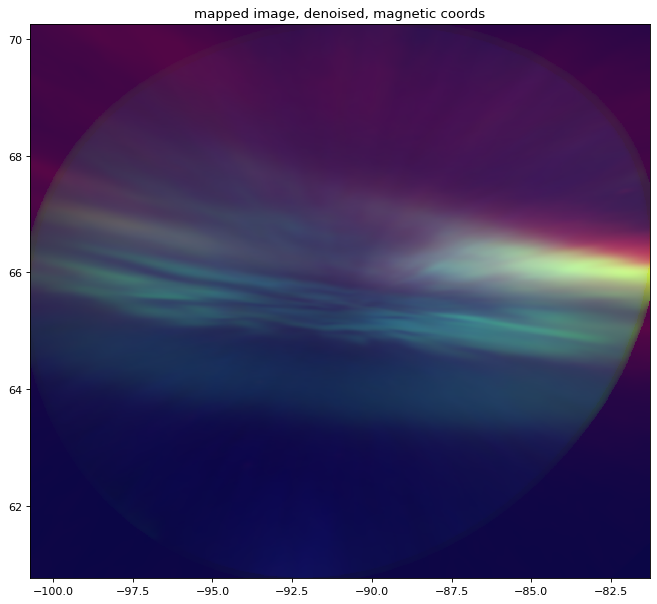

In [29]:
greenframe = np.copy(greenimdenoise)
greenframe[np.where(np.isnan(greenframe))] = greenbgbright

blueframe = np.copy(blueimdenoise)
blueframe[np.where(np.isnan(blueframe))] = bluebgbright

redframe = np.copy(redimdenoise)
redframe[np.where(np.isnan(redframe))] = redbgbright

colormat = np.asarray([nred*(redframe-redmin),ngreen*(greenframe-greenmin),nblue*(blueframe-bluemin)]).astype(float)

colormat /= maxbright

fig = figure(figsize=(10, 9), dpi=80)
fig.canvas.header_visible = False
mesh = plt.pcolormesh(maglon.T,maglat.T,greenframe.T,facecolors=colormat.T.reshape(-1,3))
mesh.set_array(None)
plt.title('mapped image, denoised, magnetic coords')

# Now we have the preprocessed image, let's convert it to Rayleighs according to the *approximate* nominal calibrations

### Use the radioactive source calibrations to *roughly* convert counts -> rayleighs

In [30]:
redray,greenray,blueray = to_rayleighs(redimdenoise,greenimdenoise,blueimdenoise,redbgbright,greenbgbright,bluebgbright)

## Let's set every pixel that does not have a valid RGB coordinate to NaN

In [31]:
badrange = np.where(np.isnan(redray+blueray+greenray))
redray[badrange] = np.nan
greenray[badrange] = np.nan
blueray[badrange] = np.nan

In [32]:
negatives = np.zeros_like(blueray)
negatives[np.where( (redray<0) | (blueray<0) | (greenray<0) )] = 1
negatives[np.where(np.isnan(blueray))] = np.nan

In [33]:
plt.pcolormesh(lon110,lat110,negatives)
plt.title('Yellow is regions where any brightnesses are negative')

Text(0.5, 1.0, 'Yellow is regions where any brightnesses are negative')

### Unfortunately we almost certainly have a few pixels that have negative brightnesses - we could set these to zeros, but we set them to NaNs

In [54]:
redray[np.where(redray<0)]=np.nan
greenray[np.where(greenray<0)]=np.nan
blueray[np.where(blueray<0)]=np.nan
badrange = np.where(np.isnan(redray+blueray+greenray))

redray[badrange] = np.nan
greenray[badrange] = np.nan
blueray[badrange] = np.nan

## Finally, let's decimate for time efficiency

In [68]:
dec = 8
# Note: dec=2 returns the original resolution, no need to do dec=1

In [69]:
redraydec = redray[::dec,::dec]
blueraydec = blueray[::dec,::dec]
greenraydec = greenray[::dec,::dec]

Text(0.5, 1.0, 'mapped image, decimated, magnetic coords - usable region only')

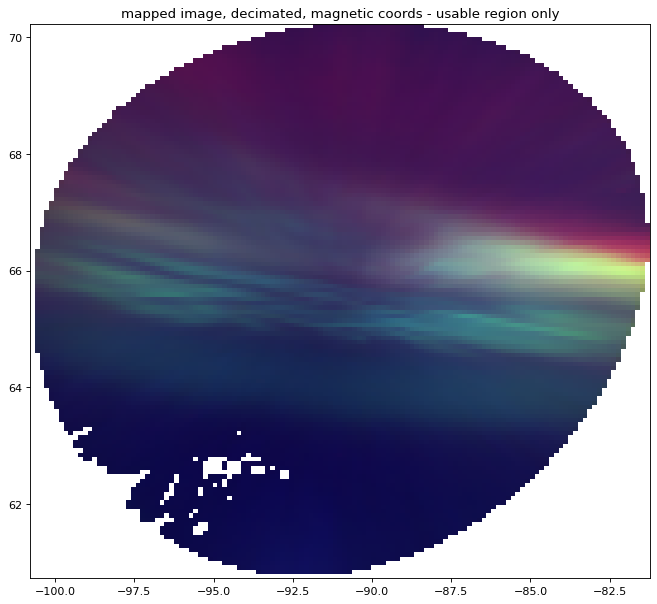

In [74]:
greenframe = np.copy(greenimdenoise)[::dec,::dec]
greenframe[np.where(np.isnan(greenframe))] = greenbgbright

blueframe = np.copy(blueimdenoise)[::dec,::dec]
blueframe[np.where(np.isnan(blueframe))] = bluebgbright

redframe = np.copy(redimdenoise)[::dec,::dec]
redframe[np.where(np.isnan(redframe))] = redbgbright

colormat = np.asarray([nred*(redframe-redmin).T,ngreen*(greenframe-greenmin).T,nblue*(blueframe-bluemin).T]).astype(float)

colormat /= maxbright

fig = figure(figsize=(10, 9), dpi=80)
fig.canvas.header_visible = False
mesh = plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],greenframe,facecolors=colormat.T.reshape(-1,3),shading='nearest')
mesh.set_array(None)
plt.title('mapped image, decimated, magnetic coords')

plt.show()

colormat[0,:][np.where(negatives[::dec,::dec].T == 1)] = 1
colormat[1,:][np.where(negatives[::dec,::dec].T == 1)] = 1
colormat[2,:][np.where(negatives[::dec,::dec].T == 1)] = 1
colormat[0,:][np.where(np.isnan((redimdenoise+greenimdenoise+blueimdenoise)[::dec,::dec].T))] = 1
colormat[1,:][np.where(np.isnan((redimdenoise+greenimdenoise+blueimdenoise)[::dec,::dec].T))] = 1
colormat[2,:][np.where(np.isnan((redimdenoise+greenimdenoise+blueimdenoise)[::dec,::dec].T))] = 1


fig = figure(figsize=(10, 9), dpi=80)
fig.canvas.header_visible = False
mesh = plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],greenframe,facecolors=colormat.T.reshape(-1,3))
mesh.set_array(None)
plt.title('mapped image, decimated, magnetic coords - usable region only')

# Invert to Q,E0:

In [80]:
qout,e0out,minq,maxq,mine0,maxe0 = calculate_E0_Q_v2(redraydec,greenraydec,blueraydec,v,minE0=150,generous=False)

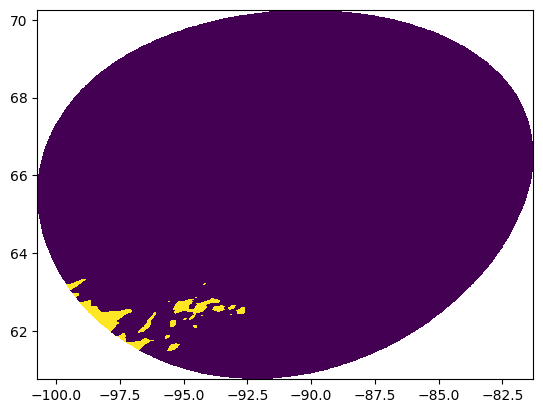

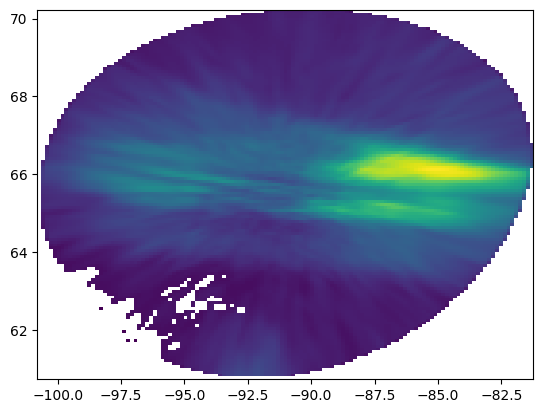

In [81]:
plt.pcolormesh(maglon,maglat,negatives)
plt.show()
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],qout)


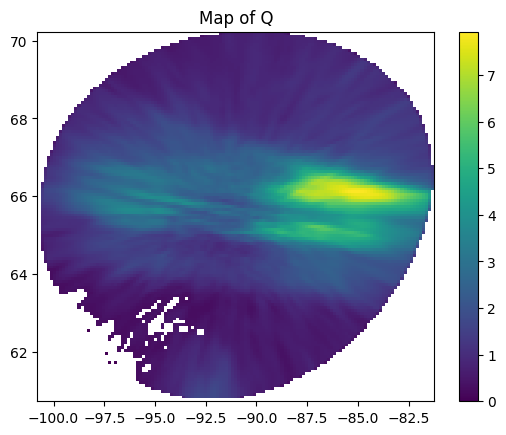

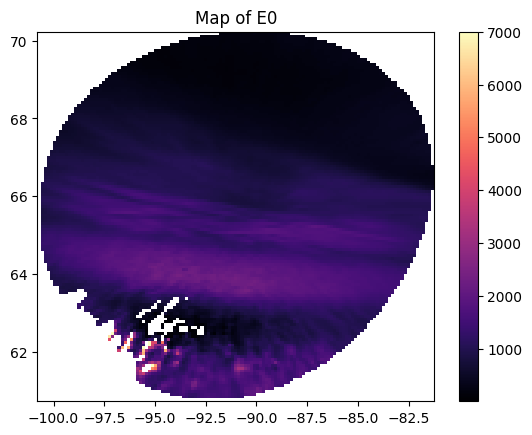

In [88]:
plt.title('Map of Q')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],qout,shading='nearest')
plt.colorbar()
plt.show()
plt.title('Map of E0')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],e0out,cmap='magma',vmax=7000,shading='nearest')
plt.colorbar()
plt.show()

# Calculate SigP, SigH

## Note: The densities used for conductance estimation are zeroth order estimations above a certain altitude and should not be trusted!

In [89]:
SigP,SigH = calculate_Sig(qout,e0out,v,generous=False)

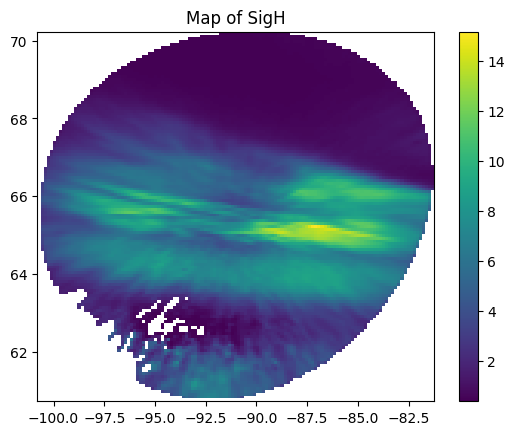

In [90]:
plt.title('Map of SigP')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],SigP)
plt.colorbar()
plt.show()
plt.title('Map of SigH')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],SigH)
plt.colorbar()
plt.show()

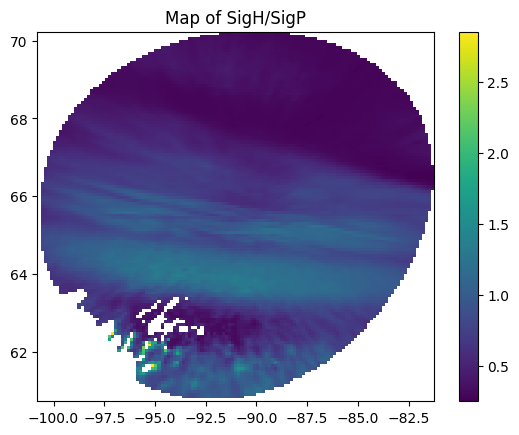

In [91]:
plt.title('Map of SigH/SigP')
plt.pcolormesh(maglon[::dec,::dec],maglat[::dec,::dec],SigH/SigP)
plt.colorbar()
plt.show()